In [12]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
df = sns.load_dataset("mpg")

X_train, y_train = df[~df["horsepower"].isna()][["displacement", "acceleration"]], df[~df["horsepower"].isna()]["horsepower"]
X_pred = df[df["horsepower"].isna()][["displacement", "acceleration"]]

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_pred)
y_pred = np.round(y_pred)
df.loc[X_pred.index, "horsepower"] = y_pred
df = pd.get_dummies(df.drop("name", axis = 1), columns = ["origin"])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [14]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [15]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [16]:
from evolutionary_algos import EvoMLPRegressor

In [17]:
regressor = EvoMLPRegressor(n = 240, hidden_layers = [16], activation = "relu", random_state = 42)
regressor.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 7.737057559160331 - val_loss: 8.01487563511419
Epoch 1 - loss: 7.510337673230257 - val_loss: 8.968483377841576
Epoch 2 - loss: 6.377420140952028 - val_loss: 6.9153560270193095
Epoch 3 - loss: 5.9939748253573955 - val_loss: 4.562573231910427
Epoch 5 - loss: 5.499161239557312 - val_loss: 5.485191682370012
Epoch 6 - loss: 4.887186262069538 - val_loss: 3.8535442732701086
Epoch 7 - loss: 3.5276069087480133 - val_loss: 3.29867082785517
Epoch 12 - loss: 3.179492032566687 - val_loss: 3.077553677544482
Epoch 16 - loss: 2.6496372645090918 - val_loss: 2.5816234634509536
Epoch 23 - loss: 2.4667274782251094 - val_loss: 2.262540538750428
Epoch 26 - loss: 2.4046516330773655 - val_loss: 2.400593384755581
Epoch 27 - loss: 2.4018009660347706 - val_loss: 1.9000964356113315
Epoch 28 - loss: 2.325062278892694 - val_loss: 2.0498219454536946
Epoch 30 - loss: 2.285079059771173 - val_loss: 2.053817912661836
Epoch 31 - loss: 2.275315911900782 - val_loss: 1.7066706653447077
Epoch 34 - loss: 2.233

Loss on test data: 1.5985694366734164


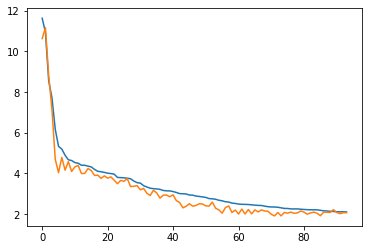

In [7]:
y_pred = regressor.predict(scaled_X_test)
print(f"Loss on test data: {mean_absolute_error(y_test, y_pred)}")

fig, ax = plt.subplots(1, 1)

ax.plot(regressor.training_loss_history)
ax.plot(regressor.validation_loss_history)

plt.show()

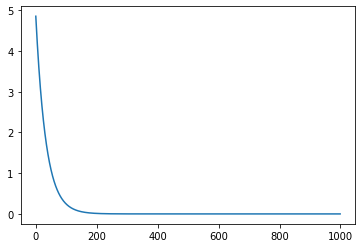

In [8]:
y = []
xrange = 1000

for x in range(1, xrange + 1):
    y.append(5 * 1 / math.exp(x / (xrange / (10 * math.log10(xrange)))))

plt.plot(list(range(xrange)), y)